In [1]:
import pandas as pd 

In [2]:
EnglishGermanData = pd.read_csv("deu.txt", sep = '\t')

In [6]:
EnglishGermanData['Go.']

0                                                       Hi.
1                                                       Hi.
2                                                      Run!
3                                                      Run.
4                                                      Wow!
                                ...                        
249224    If someone who doesn't know your background sa...
249225    If someone who doesn't know your background sa...
249226    It may be impossible to get a completely error...
249227    I know that adding sentences only in your nati...
249228    Doubtless there exists in this world precisely...
Name: Go., Length: 249229, dtype: object

In [8]:
EnglishGermanData['Geh.']

0                                                    Hallo!
1                                                Grüß Gott!
2                                                     Lauf!
3                                                     Lauf!
4                                               Potzdonner!
                                ...                        
249224    Wenn jemand Fremdes dir sagt, dass du dich wie...
249225    Wenn jemand, der nicht weiß, woher man kommt, ...
249226    Es ist wohl unmöglich, einen vollkommen fehler...
249227    Ich weiß wohl, dass das ausschließliche Beitra...
249228    Ohne Zweifel findet sich auf dieser Welt zu je...
Name: Geh., Length: 249229, dtype: object

In [20]:
import tensorflow as tf 
TfEnglishGerman = tf.data.Dataset.from_tensor_slices((EnglishGermanData['Go.'], EnglishGermanData['Geh.']))

In [23]:
for p in TfEnglishGerman.take(2):
  print(p[0].numpy().decode("utf-8"), p[1].numpy().decode("utf-8"))

Hi. Hallo!
Hi. Grüß Gott!


In [25]:
print(len(TfEnglishGerman))

249229


After inspecting the text file I was alone to see that we have around 250,000 instances in our data. It would not hurt to only use 1/5 of this, so lets just grab that many.

In [26]:
SampledTFEnglishGerman = TfEnglishGerman.take(50000)
print(len(SampledTFEnglishGerman))

50000


In [28]:
for j in SampledTFEnglishGerman.take(20):
  print(j[0].numpy().decode("utf-8"), j[1].numpy().decode("utf-8"))

Hi. Hallo!
Hi. Grüß Gott!
Run! Lauf!
Run. Lauf!
Wow! Potzdonner!
Wow! Donnerwetter!
Duck! Kopf runter!
Fire! Feuer!
Help! Hilfe!
Help! Zu Hülf!
Stay. Bleib!
Stop! Stopp!
Stop! Anhalten!
Wait! Warte!
Wait. Warte.
Begin. Fang an.
Do it. Mache es!
Do it. Tue es.
Go on. Mach weiter.
Hello! Hallo!


In [29]:
#Im curious to know if this method takes the first 50000 instances or if it takes instances at random? The docs isnt very clear so lets see if first 20 instances in original dataset
#match the first twenty instancs in this dataset. Upon looking at the dataset I notice a bulk of the text is in the last thousands of instances. So intead lets grab from the last approx 50,000 instances

for j in TfEnglishGerman.take(20):
  print(j[0].numpy().decode("utf-8"), j[1].numpy().decode("utf-8"))

Hi. Hallo!
Hi. Grüß Gott!
Run! Lauf!
Run. Lauf!
Wow! Potzdonner!
Wow! Donnerwetter!
Duck! Kopf runter!
Fire! Feuer!
Help! Hilfe!
Help! Zu Hülf!
Stay. Bleib!
Stop! Stopp!
Stop! Anhalten!
Wait! Warte!
Wait. Warte.
Begin. Fang an.
Do it. Mache es!
Do it. Tue es.
Go on. Mach weiter.
Hello! Hallo!


In [30]:
TrainingENDEDATA = TfEnglishGerman.skip(200000) #Grabs last 49,229 instances

In [31]:
print(len(TrainingENDEDATA))

49229


In [32]:
for z in TrainingENDEDATA.take(10):
  print(z[0].numpy().decode("utf-8"), z[1].numpy().decode("utf-8"))

Tom said that somebody here needed help. Tom sagte, dass hier jemand Hilfe brauche.
Tom said there's nothing else we can do. Tom sagte, wir können nichts weiter machen.
Tom said there's nothing else we can do. Tom hat gesagt, dass wir sonst nichts tun können.
Tom said you were meeting him for lunch. Tom sagte, du wolltest dich mit ihm zum Mittagessen treffen.
Tom says he hasn't made up his mind yet. Tom sagt, dass er sich noch nicht entschieden hat.
Tom says he heard Mary and John arguing. Tom sagt, er habe Maria und Johannes streiten hören.
Tom says he heard that Mary needed help. Tom meint, er habe gehört, dass Maria Hilfe brauche.
Tom says he hopes you'll be able to win. Tom sagt, er hoffe, du gewinnest.
Tom says he's fluent in three languages. Tom sagt, er spreche drei Sprachen fließend.
Tom says he's given it a lot of thought. Tom sagt, er habe viel darüber nachgedacht.


Since we are going to be making a dynamical model, we dont really need to fix the size of the data to a certain token length, they can all vary. However lets just check to see the length of the longest sentence to see what the max length is.

In [34]:
englishmax = 0
import numpy as np 
for obj in TrainingENDEDATA.take(len(TrainingENDEDATA)):
  if len(obj[0].numpy().decode("utf-8").split())>englishmax:
    englishmax = len(obj[0].numpy().decode("utf-8").split())
germanmax = 0
for obj1 in TrainingENDEDATA.take(len(TrainingENDEDATA)):
  if len(obj[1].numpy().decode("utf-8").split())> germanmax:
    germanmax = len(obj[1].numpy().decode("utf-8").split())

In [36]:
print(englishmax, germanmax) #Longest sequence of words in english data is 101 words, and in the german its 76 words. so tbh I want to tokenize these and pad to length 128

101 76


In [44]:
cleanedenglish = []
cleanedgerman = []
for vals in TrainingENDEDATA.take(len(TrainingENDEDATA)):
  cleanedenglish.append(vals[0].numpy().decode("utf-8"))
  cleanedgerman.append(vals[1].numpy().decode("utf-8"))
#Now after we grab the above lets remove anything thats not a a-Z letter and not a number between 0-9 
import re 
cleanedenglish = [re.sub(r'[^a-zA-Z0-9]', ' ', entext) for entext in cleanedenglish]
cleanedgerman = [re.sub(r'[^a-zA-Z0-9]', ' ', detext) for detext in cleanedgerman]
#Now that this is cleaned lets put it into a dataset and prepare the tokenizer.
CleanedENDEDATA = tf.data.Dataset.from_tensor_slices((cleanedenglish, cleanedgerman)) 

## Starting the TextVectorization Process

In [47]:
npenglish = np.array(cleanedenglish)
npgerman = np.array(cleanedgerman)
unique_en_words = len(set(npenglish.flatten()))
unique_german_words = len(set(npgerman.flatten()))
print(unique_en_words, unique_german_words)

42117 47254


In [48]:
endummydata = tf.data.Dataset.from_tensor_slices(cleanedenglish)
dedummydata = tf.data.Dataset.from_tensor_slices(cleanedgerman)
enTextVectorizer = tf.keras.layers.TextVectorization(max_tokens = unique_en_words, standardize = 'lower_and_strip_punctuation', output_mode='int', output_sequence_length=128,
                                                     pad_to_max_tokens=True)
deTextVectorizer = tf.keras.layers.TextVectorization(max_tokens = unique_german_words, standardize='lower_and_strip_punctuation', output_mode='int', output_sequence_length=128,
                                                     pad_to_max_tokens=True)
enTextVectorizer.adapt(endummydata)
deTextVectorizer.adapt(dedummydata)

In [49]:
def TokenizeDataset(english, german):
  return enTextVectorizer(english), deTextVectorizer(german)
CleanedENDEDATA = CleanedENDEDATA.cache().shuffle(len(CleanedENDEDATA)).batch(64).map(TokenizeDataset, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [52]:
for tokenized in CleanedENDEDATA.take(1):
  print(tokenized[0], tokenized[1]) #Fair enough! So lets now take a look to make sure the length is still proper, it should be originallength/64

tf.Tensor(
[[   5 4536  944 ...    0    0    0]
 [  28   78  154 ...    0    0    0]
 [  22  702   13 ...    0    0    0]
 ...
 [   2  325  103 ...    0    0    0]
 [   4  445   11 ...    0    0    0]
 [   5  495    8 ...    0    0    0]], shape=(64, 128), dtype=int64)


In [53]:
len(CleanedENDEDATA)

770

In [54]:
print(49229/64) #Lets remove the last batch! since they rounded up.

769.203125


In [55]:
CleanedENDEDATA = CleanedENDEDATA.take(769)

In [56]:
len(CleanedENDEDATA)

769

In [57]:
#Our data seems to be ready, its in tuple form, batches, parallelized, and prepped.
#Time to make our model.
def point_wise_feed_forward_network(dff, d_model):
  return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation = 'relu'),
          tf.keras.layers.Dense(d_model) 
  ])

In [81]:
def scaled_dot_product_attention(q, v, k, mask):
  scores = tf.linalg.matmul(q,k, transpose_b=True)
  scaledscores = scores/tf.math.sqrt(tf.cast((tf.shape(v)[-1]), tf.float32))
  if mask is not None:
    scaledscores += (mask * -1e9)
  softmaxscores = tf.nn.softmax(scaledscores)
  return tf.matmul(softmaxscores, v), softmaxscores

## Positional Encoding
## Formula: cos for odds, sin for even pos/(10000^((2*i)/d_model))


In [82]:
def innerpart(position, iofd, d_model):
  return position/(np.power(10000, (2*iofd)/d_model))
def positional_encoding(maximum_position, d_model):
  untrigedarr = innerpart(np.arange(maximum_position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
  untrigedarr[:, 0::2] = np.sin(untrigedarr[:, 0::2])
  untrigedarr[:, 1::2] = np.cos(untrigedarr[:, 1::2])
  return tf.cast(untrigedarr[np.newaxis, ... ], tf.float32) #We raise the dimension for the sake of tensorflow, as the second index refers to rows and the third refers to columns.
  #The first index refers to batch index.

In [112]:
def create_look_ahead_mask(size):
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return look_ahead_mask
def create_padding_mask(sequence):
  values = tf.cast(tf.math.equal(sequence, 0), tf.float32)
  return values[:, tf.newaxis, tf.newaxis, :]

In [113]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model 
    assert self.d_model % self.num_heads == 0 #Throws an error if the dimensionality of our vector embeddings are not divisible by the number of heads we select. 
    self.depth = self.d_model//self.num_heads 
    self.wQ = tf.keras.layers.Dense(d_model)
    self.wK = tf.keras.layers.Dense(d_model)
    self.wV = tf.keras.layers.Dense(d_model)
    self.finaloutput = tf.keras.layers.Dense(d_model)
  def reshape(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    x = tf.transpose(x, perm = [0,2,1,3]) #Goes from batch -> seq_len->num_heads->depth to batch->num_heads -> seq_len -> depth
    return x
  def call(self, query, key, value, mask):
    batch_size = tf.shape(query)[0]
    q = self.wQ(query)
    k = self.wK(key)
    v = self.wV(value)
    q = self.reshape(q, batch_size)
    v = self.reshape(v, batch_size)
    k = self.reshape(k, batch_size) 
    attentionout, attentionweights = scaled_dot_product_attention(q, v, k, mask)
    attentionout = tf.transpose(attentionout, perm=[0,2,1,3])
    attentionout = tf.reshape(attentionout, (batch_size, -1, self.d_model)) #This concatenates the attention pieces again.
    linearout = self.finaloutput(attentionout)
    return linearout, attentionweights

In [114]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model, dff, rate = 0.05):
    super(EncoderLayer, self).__init__() 
    self.d_model = d_model 
    self.num_heads = num_heads
    self.ffn = point_wise_feed_forward_network(dff, d_model)
    self.mha= MultiHeadAttention(self.num_heads, self.d_model)
    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
  def call(self, input,Training,  padding_mask):
    x, _ = self.mha(input, input, input, padding_mask)
    x = self.dropout1(x, training = Training)
    x = self.layernorm1(x + input)
    ffn = self.ffn(x)
    ffn = self.dropout2(ffn, training = Training)
    ffn = self.layernorm2(ffn + x)
    return ffn

In [115]:
sample_encoder_layer = EncoderLayer(8,512, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [116]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate = 0.05):
    super(DecoderLayer, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads 
    self.ffn = point_wise_feed_forward_network(dff, d_model)
    self.mha1 = MultiHeadAttention(num_heads, d_model)
    self.mha2 = MultiHeadAttention(num_heads, d_model)
    self.ln1 = tf.keras.layers.LayerNormalization()
    self.ln2 = tf.keras.layers.LayerNormalization()
    self.ln3 = tf.keras.layers.LayerNormalization()
    self.do1 = tf.keras.layers.Dropout(rate)
    self.do2 = tf.keras.layers.Dropout(rate)
    self.do3 = tf.keras.layers.Dropout(rate)
  def call(self, input, enc_output,training, padding_mask, look_ahead_mask):
    x, attnw1 = self.mha1(input, input, input, look_ahead_mask)
    x = self.do1(x, training = training)
    x = self.ln1(x + input)
    x2,attnw2 = self.mha2(x, enc_output, enc_output, padding_mask)
    x2 = self.do2(x2, training = training)
    x2 = self.ln2(x2 + x)
    ffn1 = self.ffn(x2)
    ffn1 = self.do3(ffn1, training = training)
    ffn1 = self.ln3(ffn1 + x2)
    return ffn1, attnw1, attnw2

In [117]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [118]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, num_layers, dff, input_vocab_size, maximum_position_encoding):
    super(Encoder, self).__init__()
    self.num_layers = num_layers 
    self.d_model = d_model 
    self.enc_layers = [EncoderLayer(num_heads, d_model, dff) for _ in range(num_layers)]
    self.embedding = tf.keras.layers.Embedding(input_dim = input_vocab_size, output_dim = d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dropout = tf.keras.layers.Dropout(0.1)
  def call(self, input, training, mask):
    seq_len = tf.shape(input)[1] 
    embeddedin = self.embedding(input)
    embeddedin *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #Check if this is required too
    embeddedin += self.pos_encoding[:, :seq_len, :] #Since we have all sequences to length 128 we can check after if this argument is really necessary to get a valid training in.
    embeddedin = self.dropout(embeddedin)
    output = embeddedin 
    for z in range(self.num_layers):
      output = self.enc_layers[z](output, training, padding_mask=mask)
    return output 

In [119]:
sample_encoder = Encoder(d_model=512, num_heads=8, num_layers=2,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [120]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, num_layers, dff, target_vocab_size, maximum_position_encoding):
    super(Decoder, self).__init__()
    self.d_model = d_model 
    self.num_heads = num_heads
    self.num_layers = num_layers
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff) for _ in range(self.num_layers)]
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dropout1 = tf.keras.layers.Dropout(0.1)
    self.embedding = tf.keras.layers.Embedding(input_dim = target_vocab_size, output_dim = d_model)
  def call(self, input, enc_output, training, padding_mask, look_ahead_mask):
    seq_len = tf.shape(input)[1]
    x = self.embedding(input)
    x *= tf.math.sqrt(tf.cast(self.d_model ,tf.float32))
    attentionlist = []
    x += self.pos_encoding[:, :seq_len, :]
    for z in range(self.num_layers):
      x, attnb1, attnb2 = self.dec_layers[z](x, enc_output, training, padding_mask, look_ahead_mask)
      attentionlist.append(attnb1)
      attentionlist.append(attnb2)
    return x, attentionlist

In [121]:
sample_decoder = Decoder(d_model=512, num_heads=8,num_layers=2,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)
output.shape

TensorShape([64, 26, 512])

In [122]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate = 0.1):
    super().__init__()
    self.encoder = Encoder(d_model, num_heads, num_layers, dff, input_vocab_size, pe_input)
    self.decoder = Decoder(d_model, num_heads, num_layers, dff, target_vocab_size, pe_target)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size) #Since we are predicing over all german words
  def call(self, inputs, training):
    x, y = inputs  #Since we have a tuple as our dataset
    enc_pad_mask, dec_look_ahead_mask, dec_padding_mask = self.create_masks(x, y)
    enc_out = self.encoder(x, training, enc_pad_mask)
    dec_out, attn = self.decoder(y, enc_out, training, dec_padding_mask, dec_look_ahead_mask)
    finaloutput = self.final_layer(dec_out)
    return finaloutput, attn
  def create_masks(self, inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp) #Second attention block in decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, look_ahead_mask, dec_padding_mask 

In [123]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [124]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [129]:
class LearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(LearningRateSchedule, self).__init__()
    self.d_model = d_model 
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps =warmup_steps
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model)*tf.math.minimum(arg1,arg2)

In [130]:
optimizer = tf.keras.optimizers.Adam(learning_rate = LearningRateSchedule(d_model), epsilon = 1e-9)


Text(0.5, 0, 'Train Step')

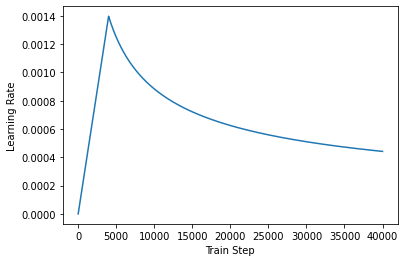

In [131]:
temp_learning_rate_schedule = LearningRateSchedule(d_model)
import matplotlib.pyplot as plt
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [133]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [135]:
def loss_func(real, pred):
  diff = loss(real, pred)
  return tf.reduce_sum(diff)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [136]:
transformer1 = Transformer(num_layers=num_layers, d_model = d_model, num_heads = num_heads, dff= dff, input_vocab_size = unique_en_words, target_vocab_size = unique_german_words,
                           pe_input= 1000, pe_target=1000)

In [138]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer1,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [139]:
EPOCHS = 20

In [140]:
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer1([inp, tar_inp],
                                 training = True)
    loss = loss_func(tar_real, predictions)

  gradients = tape.gradient(loss, transformer1.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer1.trainable_variables))

  train_loss(loss)

In [143]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 8.5 MB/s 


In [144]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [147]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(CleanedENDEDATA):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 86856.4375
Epoch 1 Batch 50 Loss 85372.7031
Epoch 1 Batch 100 Loss 83038.8594
Epoch 1 Batch 150 Loss 80909.9922
Epoch 1 Batch 200 Loss 78459.7344
Epoch 1 Batch 250 Loss 75484.2344
Epoch 1 Batch 300 Loss 71918.3828
Epoch 1 Batch 350 Loss 67723.4609
Epoch 1 Batch 400 Loss 62881.9219
Epoch 1 Batch 450 Loss 57669.7031
Epoch 1 Batch 500 Loss 52825.3789
Epoch 1 Batch 550 Loss 48706.3516
Epoch 1 Batch 600 Loss 45187.1680
Epoch 1 Batch 650 Loss 42146.6562
Epoch 1 Batch 700 Loss 39510.9141
Epoch 1 Batch 750 Loss 37207.5430
Epoch 1 Loss 36448.9922
Time taken for 1 epoch: 248.17 secs

Epoch 2 Batch 0 Loss 4897.9072
Epoch 2 Batch 50 Loss 4720.4189
Epoch 2 Batch 100 Loss 4676.4473
Epoch 2 Batch 150 Loss 4632.2920
Epoch 2 Batch 200 Loss 4589.7632
Epoch 2 Batch 250 Loss 4553.4028
Epoch 2 Batch 300 Loss 4529.7446
Epoch 2 Batch 350 Loss 4502.7759
Epoch 2 Batch 400 Loss 4472.0791
Epoch 2 Batch 450 Loss 4446.1099
Epoch 2 Batch 500 Loss 4423.1313
Epoch 2 Batch 550 Loss 4399.2222
Epoch

In [148]:
!mkdir -p saved_model
transformer1.save('saved_model/my_transformer')

INFO:tensorflow:Assets written to: saved_model/my_transformer/assets


INFO:tensorflow:Assets written to: saved_model/my_transformer/assets
